# Using Latent Semantic Indexing to Reduce Sparse Vectors

### Dipti Jasrasaria and Ed Pyzer-Knapp

Long, sparse vectors are not good inputs for machine learning, so how can one use dimensionality reduction to preserve information while eliminating sparseness?

This example walks through the concepts and MAML implementation of Latent Semantic Indexing, a tool that can be used for dimensionality reduction of sparse vectors.

### Introduction to Latent Semantic Indexing (LSI)

LSI is a tool that is often used in classifying text documents. Documents are represented as a 'bag of words.' This takes into account the number of times each word appears in a document but doesn't care about the order in which the words appear. LSI maps the document from a large 'word space' to a reduced 'concept space.'

However, we will apply this tool to reduce dimensionality of sparse vectors! In our case, a 'document' is one of the sparse vectors in our data set, and the 'words' are the non-zero indices of the sparse vector. I will use 'documents' and 'words' in my explanation of LSI, but know that these things can be applied to vectors as well.

Now, it's time to get started with implementing LSI to reduce our sparse vectors!

### Step 1: Importing required modules

First, we will import the LSI module as well as some other useful python modules.

In [1]:
import pandas as pd  # Used for reading in data.
from maml.utils import lsi # This contains all the code to perform LSI.
import numpy as np

In [2]:
# These modules are for plotting.
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')
sns.set_context('poster')

### Step 2: Reading in data set

Now, we will import the dataset of unreduced, sparse vectors. Because these vectors are sparse, they should be represented as a list of their non-zero indices.

For example, a vector that is [0, 0, 0, 2, 0, 0, 1, 0, 1, 0, 0, 3] should be represented as [3, 3, 6, 8, 11, 11, 11].

We will unpack a dataframe that contains 200 vectors that are $2^{16}$ in length but extremely sparse.

In [3]:
# load data
data = pd.read_pickle('data/sparse.pkl')
# display head of dataframe
data.head()

,Sparse Vectors
0,"[3466, 3770, 6892, 7117, 7658, 8174, 8188, 104..."
1,"[3483, 3773, 4060, 7148, 7611, 7885, 7912, 817..."
2,"[3483, 3773, 4060, 7148, 7611, 7885, 7912, 817..."
3,"[3483, 3773, 4060, 7148, 7611, 7885, 7912, 817..."
4,"[3038, 4057, 8136, 12253, 15597, 16270, 19082,..."


Now we will set these sparse vectors as a set of documents so that it can be used for LSI. 

In [4]:
documents = data['Sparse Vectors'].values

### Step 3: Building counts matrix

The first step of LSI is to build a counts matrix that states how many times each word appears in each document. However, the counts matrix is only concerned with words that appear in more than one document.

This builds an extremely large but extremely sparse matrix. MAML's implementation of LSI takes advantage of the sparseness to require less time and memory.

### Step 4. Modifying counts

The next step is to modify the counts using Term Frequency-Inverse Document Frequency (TF-IDF).

This gives a higher weight to words that are uncommon and a lower weight to very common words. This is because the occurence of an uncommon word, like 'xylophone,' gives much more insight into a document's meaning than the occurrence of a word, like 'the,' that appears all the time.

### Step 5. Reducing using Singular Value Decomposition

Finally, we will reduce the modified counts matrix using Singular Value Decomposition (SVD).
 
SVD decomposes the modified counts matrix, A (which is n documents mapped onto a space of m words), into three other matrices:
1. **U matrix** - this is the mapping of m words onto a k-dimensional concept space
2. **S matrix** - this is a diagonal, k by k, matrix of singular values; the singular value for a dimension tells you how much that dimension of the reduced concept space contributes to the overall space
3. **Vt matrix** - this is the mapping of n documents onto a k-dimensional concept space

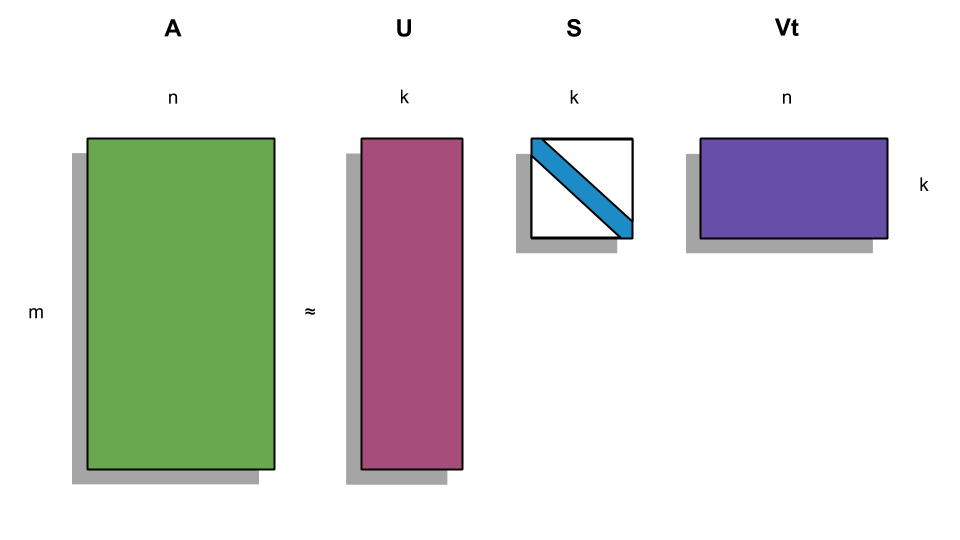

In [5]:
Image(filename='svd.png')

### Step 6. Finding the right K value

The next step is to figure out the right k-value, the number of dimensions in our reduced concept space.

We want to find a k that is big enough that it retains much of the information in the sparse vectors but that is small enough that it doesn't include extra noise.

Unfortunately, there's no rigorous way to calculate the optimal k value. Instead, the best way is to plot the singular values and determine where the curve begins to level off. Let's do that now by plotting the first 50 singular values for the concept space!

In [6]:
svs = lsi.get_svs(documents, k=50)

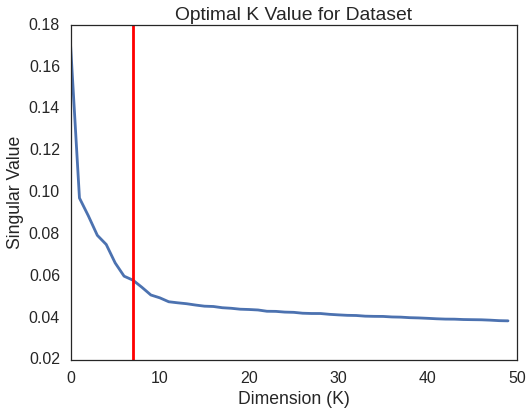

In [7]:
plt.figure(figsize=(8, 6))
plt.plot(svs)
plt.axvline(x=7, color='red')
plt.title('Optimal K Value for Dataset')
plt.xlabel('Dimension (K)')
plt.ylabel('Singular Value')

As we can see in the plot above, the singular values start to level off at 7, making it a good k value to choose.  We can also take advantage of the fact that you can relate the reconstruction error (the Frobenius norm of the difference between the reconstructed matrix to the initial matrix) to the sum of the discarded singular values.

As a quick reminder, the Frobenius norm (sometimes called the Hilbert–Schmidt norm) can be defined as:

$\|A\|_F=\sqrt{\sum_{i=1}^m\sum_{j=1}^n |a_{ij}|^2}=\sqrt{\operatorname{trace}(A^{{}^*}A)}=\sqrt{\sum_{i=1}^{\min\{m,\,n\}} \sigma_i^2}$

where $A*$ denotes the conjugate transpose of $A$, and $\sigma_{i}$ are the singular values of A

In [8]:
reconstruction_error = [np.sum(np.array(svs[i:])) for i in range(len(svs))]

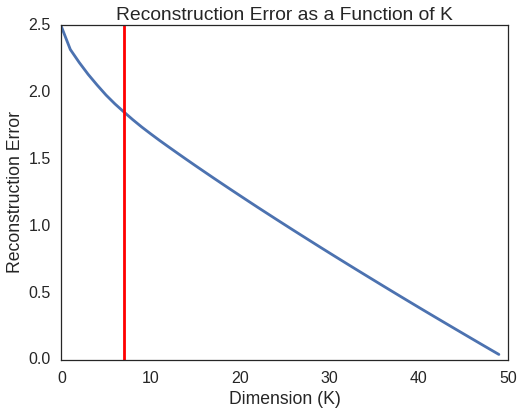

In [9]:
plt.figure(figsize=(8, 6))
plt.plot(reconstruction_error)
plt.axvline(x=7, color='red')
plt.title('Reconstruction Error as a Function of K')
plt.xlabel('Dimension (K)')
plt.ylabel('Reconstruction Error')

Now, that we know the k value we want and we know how LSI works, we can use it to reduce our sparse vectors. The following function executes steps 3 through 5 that are described above and returns an array of the reduced vectors.

### Step 7. Running LSI to reduce vectors

In [10]:
reduced_docs = lsi.LSI(documents, k=7, return_svs=False)

Because we're not interested in seeing our singular values again, we set 'return_svs' to False. However, if we did want to see the singular values, we could set that parameter to True.

### Step 8. Saving vectors for later use

Now that we have our reduced vectors, let's save them so that we can use them to do more cool things, like machine learning. We'll first create a dataframe and then write it to a pickle file.

In [11]:
# create dataframe
d = {'Reduced Vectors': reduced_docs}
df = pd.DataFrame(data=d)
# write to pickle
df.to_pickle('data/reduced.pkl')

In [12]:
# display head of dataframe
df.head()

,Reduced Vectors
0,"[-0.0167576855395, 0.0198265284539, 0.00379064..."
1,"[-0.00183582297102, -0.00261856246365, 0.00796..."
2,"[-0.00179665484873, -0.00266041060702, 0.00792..."
3,"[0.00203753062206, -0.00222866909215, 0.002504..."
4,"[-0.000413956829628, -0.000427230220381, -0.00..."


As we can see, these vectors are much shorter and less sparse than our original vectors -- much better for things like machine learning. To learn more about machine learning and how to implement certain algorithms, check out MAML's [tutorial on neural networks](https://github.com/epyzerknapp/maml/blob/master/examples/Example1-NeuralNetworksWithMAML.ipynb)!